In [2]:
#########
# Kernel Density Estimation from R to python
#########

import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
import matplotlib.pylab as plt 
from six import string_types
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6

sys.path.append('/Users/peterpfleiderer/Documents/0p5_observed/')

try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")


# Variable
varin='TX90p'
read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc')['Ann']

# Set working dir

#Set annual time axis for input data 
timeaxis=np.arange(1901,2011)

# Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2010
input_data=da.DimArray(read_in_data[:20100101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )

0p5 reference period for  Nasa 2010 :  [1960, 1979]
No of non-NAN grid cells in Mask over Ref period:  1415
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  1216


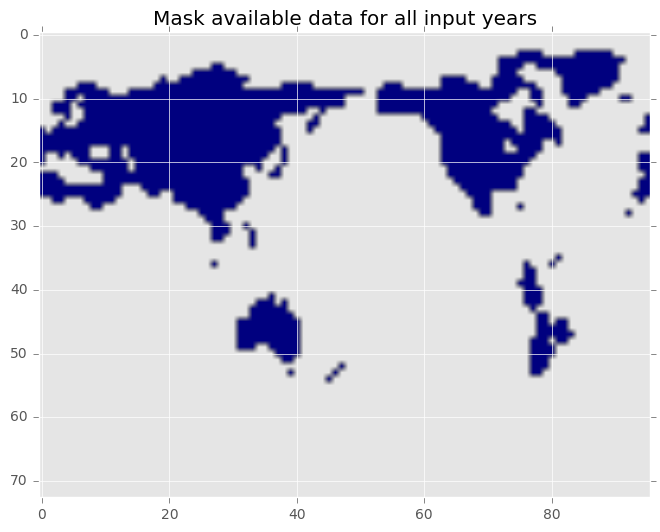

In [3]:


###########
# Settings
###########

# Set GMT dataset
gmtds='Nasa'

# Set Final year in Extreme Event database with sufficient coverage
# 2013 for GHCND, 2010 for HadEx2
ref_year=2010

dgmtp=np.load('/Users/peterpfleiderer/Box Sync/0p5_observational_record/scripts/GMT_time_series/GMT_0p5_diff_intervals.dat')

# print dgmtp#,ref_year,gmtds
ref_period=dgmtp[ref_year][gmtds][::-1]

print '0p5 reference period for ',gmtds,ref_year,': ',ref_period
target_periods=[[ref_year-19,ref_year]]
period_names=['Recent','ref']


# Mask for data availability
varpdf=pdf.PDF_Processing(varin,'/Users/peterpfleiderer/Documents/0p5_observed/')
varpdf.mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods)

# Plot data mask
plt.figure()
plt.imshow(varpdf._masks['refmask'][::-1,:])
plt.title('Mask available data for all input years')

plt.show()

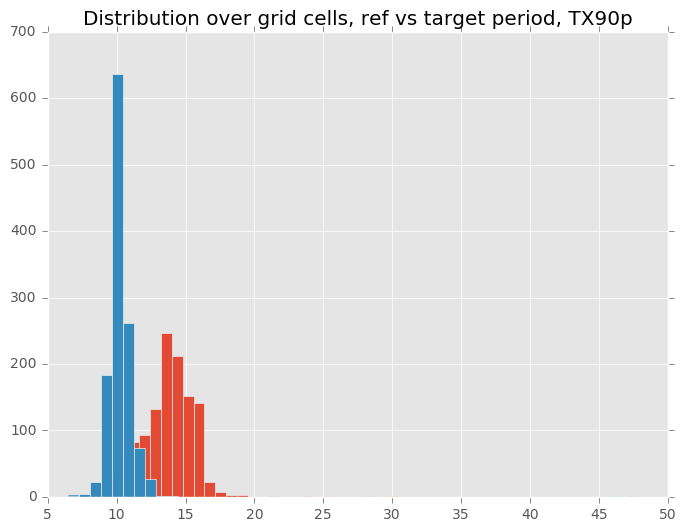

In [10]:


###########
# Derive time slices
###########
varpdf.derive_time_slices(input_data,ref_period,target_periods,period_names)
varpdf.derive_distributions()

plt.figure()
for key in varpdf._periods:
    plt.hist(varpdf._distributions['global'][key],bins=50)
plt.title('Distribution over grid cells, ref vs target period, '+ varin)
plt.show()

[5.8242211818695067, 57.368508911132814] 1.28860719323


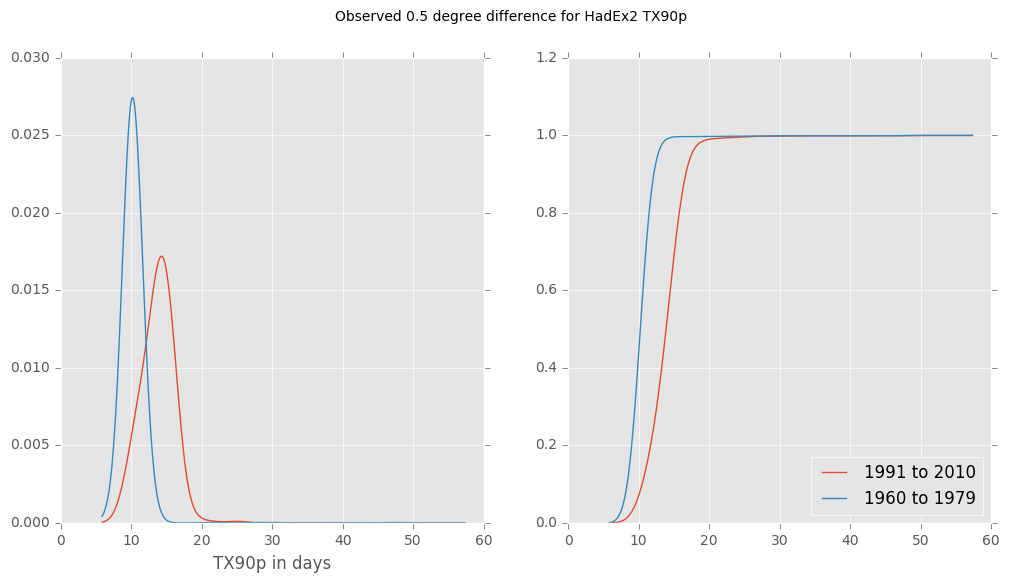

In [11]:
###########
# DERIVE PDF/CDFs
###########

# Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
cutinterval=[varpdf._distributions['global']['ref'].min()*0.9,varpdf._distributions['global']['Recent'].max()*1.2]
# Set bandwith for kernel estimate
bw=(cutinterval[1]-cutinterval[0])/40
# Derive Kernel estimate
varpdf.kernel_in_R(cutinterval,bw)

print cutinterval,bw

# Plot
f,pl=plt.subplots(ncols=2,figsize=(12,6))

# Legend Dict
ldict={
    'ref':str(ref_period[0])+' to '+str(ref_period[1]),
    'Recent':str(target_periods[0][0])+' to '+str(target_periods[0][1])
}

for key in varpdf._periods:
    pdf_distro=varpdf._distributions['global'][key+'_pdf']
    pl[0].plot(pdf_distro[:,0],pdf_distro[:,1],label=ldict[key])    
    cdf_distro=varpdf._distributions['global'][key+'_cdf']
    pl[1].plot(cdf_distro[:,0],cdf_distro[:,1],label=ldict[key])

pl[1].legend(loc='lower right')
pl[0].set_xlabel(varin+' in days')
f.suptitle('Observed 0.5 degree difference for HadEx2 '+varin)
plt.savefig('plots/Observed_0p5_degree_difference_for_HadEx2_'+varin+'.pdf')
plt.show()

#print varpdf._distributions['global']['ref_pdf']

[ 0.00092457  0.00096402  0.00096402 ...,  0.00017067  0.00017067
  0.00017067]
[ 0.00092457  0.00096402  0.00096402 ...,  0.00017067  0.00017067
  0.00017067]
[5.8242211818695067, 57.368508911132814] 1.28860719323


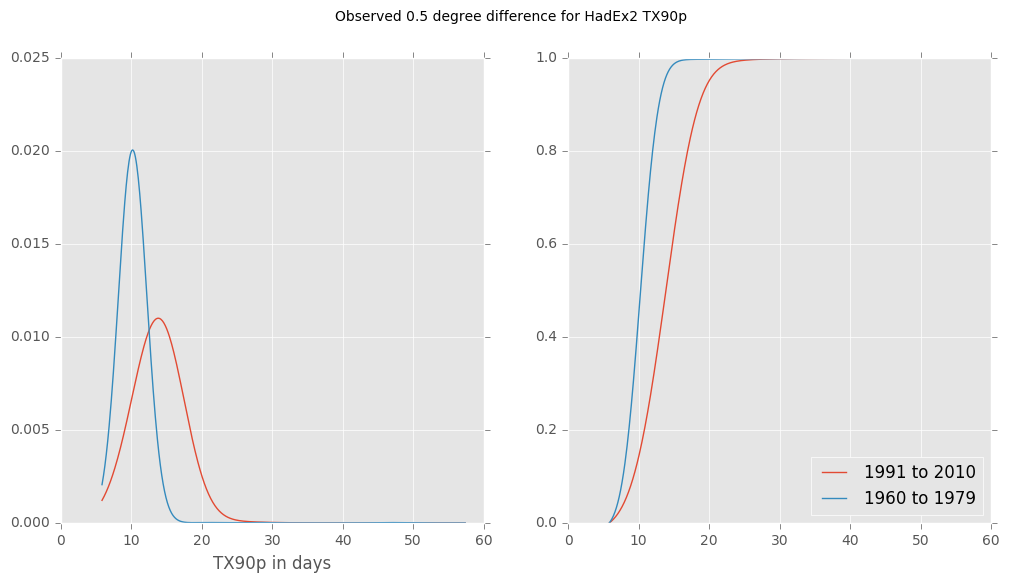

In [12]:
from scipy.stats import gaussian_kde
###########
# DERIVE PDF/CDFs
###########

# Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
cutinterval=[varpdf._distributions['global']['ref'].min()*0.9,varpdf._distributions['global']['Recent'].max()*1.2]
# Set bandwith for kernel estimate
bw=(cutinterval[1]-cutinterval[0])/40
# Derive Kernel estimate
varpdf.kernel_in_PY(cutinterval,bw)

print cutinterval,bw

# Plot
f,pl=plt.subplots(ncols=2,figsize=(12,6))

# Legend Dict
ldict={
    'ref':str(ref_period[0])+' to '+str(ref_period[1]),
    'Recent':str(target_periods[0][0])+' to '+str(target_periods[0][1])
}

for key in varpdf._periods:
    pdf_distro=varpdf._distributions['global'][key+'_pdf']
    pl[0].plot(pdf_distro[:,0],pdf_distro[:,1],label=ldict[key])    
    cdf_distro=varpdf._distributions['global'][key+'_cdf']
    pl[1].plot(cdf_distro[:,0],cdf_distro[:,1],label=ldict[key])

pl[1].legend(loc='lower right')
pl[0].set_xlabel(varin+' in days')
f.suptitle('Observed 0.5 degree difference for HadEx2 '+varin)
plt.savefig('plots/Observed_0p5_degree_difference_for_HadEx2_'+varin+'.pdf')
plt.show()

#print varpdf._distributions['global']['ref_pdf']

In [5]:
print read_in_data.lon



[   0.      3.75    7.5    11.25   15.     18.75   22.5    26.25   30.
   33.75   37.5    41.25   45.     48.75   52.5    56.25   60.     63.75
   67.5    71.25   75.     78.75   82.5    86.25   90.     93.75   97.5
  101.25  105.    108.75  112.5   116.25  120.    123.75  127.5   131.25
  135.    138.75  142.5   146.25  150.    153.75  157.5   161.25  165.
  168.75  172.5   176.25  180.    183.75  187.5   191.25  195.    198.75
  202.5   206.25  210.    213.75  217.5   221.25  225.    228.75  232.5
  236.25  240.    243.75  247.5   251.25  255.    258.75  262.5   266.25
  270.    273.75  277.5   281.25  285.    288.75  292.5   296.25  300.
  303.75  307.5   311.25  315.    318.75  322.5   326.25  330.    333.75
  337.5   341.25  345.    348.75  352.5   356.25]
